In [1]:
import numpy as np
import matplotlib.pyplot as plt
import numba 
from numba import jit

from matplotlib import animation
from mpl_toolkits.axes_grid1 import make_axes_locatable

$$\frac{\partial T}{\partial t} = \alpha^2 \Delta T -\beta (T-T_0)$$
$$\Delta = \frac{\partial^2 }{\partial x^2} +  \frac{\partial^2 }{\partial y^2}$$

$$\frac{\partial T}{\partial t} = \alpha^2 [\frac{\partial^2 T}{\partial x^2} +  \frac{\partial^2 T}{\partial y^2}] -\beta (T-T_0)$$

Boundaries:

$$T(x, y, t)|x^2 + y^2 = r_{beam}^2 = T_{laser}$$

$$T(x, y, t)|x^2 + y^2 \geq r_{beam}^2 = T_{atmosphere}$$

In [2]:
dx_size = 0.125 #mm
dy_size = 0.125 #mm
dt = 0.5
a_sauce = 1.92e-4

gridsize = np.arange(0, 20, dx_size) #mm 
xv, yu = np.meshgrid(gridsize, gridsize)

In [3]:
s = a_sauce * dt / (dx_size ** 2)
s

0.006144

For convergence of computations $ s = \alpha dt/dx^2 << 1/4$

In [4]:
def circle_mask(x_shape, y_shape, x0, y0, r):
    mask = np.zeros((x_shape, y_shape))
    
    for i in range(x_shape):
        for j in range(y_shape):
            if (x0 - i) ** 2 + (y0 - j) ** 2 <= r**2:
                mask[i][j] = 1
                
    return mask.astype(bool)

def circle_on_array(x_shape, y_shape, x0, y0, r):
    mask = np.zeros((x_shape, y_shape))
    
    for i in range(x_shape):
        for j in range(y_shape):
            if (x0 - i) ** 2 + (y0 - j) ** 2 <= r**2:
                mask[i][j] = 1
                
    return mask.astype(int)

In [5]:
initial_tempreature = 25 + 273.15 #Celsicus deg
laser_tempareature  = 70 + 273.16

temperature = np.zeros((160, 160)) + initial_tempreature
laser_mask = circle_mask(160, 160, 80, 80, 1/dx_size) #1 is for 1mm
sauce_mask = circle_on_array(160, 160, 80, 80, 5/dx_size)  - circle_on_array(160, 160, 80, 80, 1/dx_size)  #5 is for 5mm
sauce_mask = sauce_mask.astype(bool)

temperature[laser_mask] = laser_tempareature

### Plot of laser beam in image center

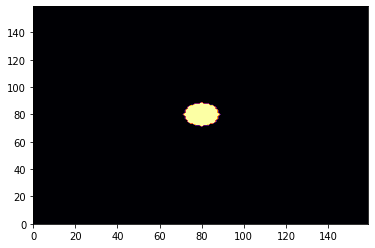

In [6]:
plt.contourf(temperature, vmin = initial_tempreature, vmax=laser_tempareature, cmap='inferno')

### Plot of sauce mask

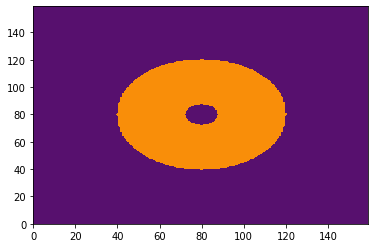

In [7]:
plt.contourf(sauce_mask, cmap='inferno')

In [8]:
times = 180000
frame_iteration = 10
times_snapshot = int(times / frame_iteration)

In [9]:
heat_frames = np.zeros([times_snapshot, 160, 160])
heat_frames[0] = temperature

## Diffusive model
For simple equation, such as: 
$$\frac{\partial T}{\partial t} = \alpha^2 \Delta T =  \alpha^2 [\frac{\partial^2 T}{\partial x^2} +  \frac{\partial^2 T}{\partial y^2}]  $$

solution can be derived with easy grid based Eulier method: 

$$\frac{\partial T}{\partial t} = \alpha^2 \Delta T =  \alpha^2 [\frac{T_{i+1, j}^{(m)} - 2T_{i, j}^{(m)} + T_{i-1, j}^{(m)}}{\Delta x^2} +  \frac{T_{i, j+1}^{(m)} - 2T_{i, j}^{(m)} + T_{i, j-1}^{(m)}}{\Delta y^2}] =  \frac{T_{i, j}^{(m+1)} - T_{i, j}^{(m)}}{\Delta t}$$

In [10]:
@numba.jit("f8[:,:,:](f8[:,:,:], b1[:,:])", nopython=True, nogil=True)
def solve_heat(heatmap, sauce_mask):
    current_state  = heatmap[0].copy()
    x_size, y_size = current_state.shape
    current_frame  = 0
    
    for t in range(1, times):
        new_state = current_state.copy()
        for i in range(1, x_size - 1):
            for j in range(1, y_size - 1):
                if sauce_mask[i][j]:
                    new_state[i][j] = current_state[i][j] + a_sauce*dt/dx_size**2 * \
                        (current_state[i+1][j] + current_state[i-1][j] + current_state[i][j+1] + current_state[i][j-1] - 4*current_state[i][j])
        current_state = new_state.copy()
        
        if t % frame_iteration == 0:      
            current_frame += 1
            heatmap[current_frame] = current_state

    return heatmap

In [11]:
heat_frames = solve_heat(heat_frames, sauce_mask)
heat_frames -= 273.15

In [12]:
heat_frames[-1]

array([[25., 25., 25., ..., 25., 25., 25.],
       [25., 25., 25., ..., 25., 25., 25.],
       [25., 25., 25., ..., 25., 25., 25.],
       ...,
       [25., 25., 25., ..., 25., 25., 25.],
       [25., 25., 25., ..., 25., 25., 25.],
       [25., 25., 25., ..., 25., 25., 25.]])

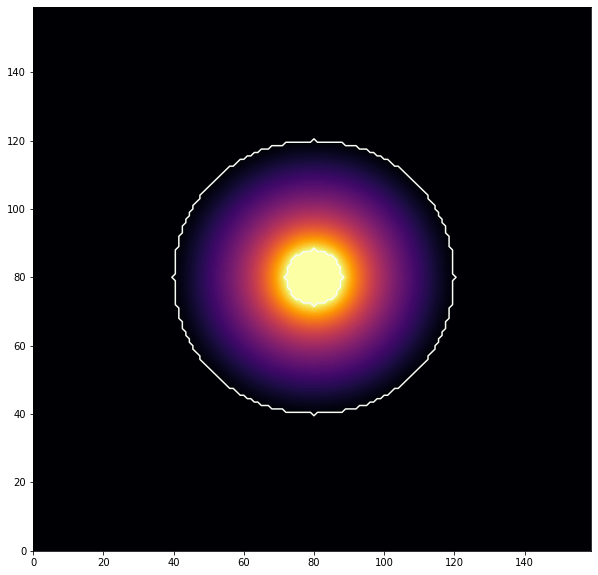

In [20]:
plt.figure(figsize=(10, 10))
plt.contour(sauce_mask, cmap='Greens')
plt.contourf(heat_frames[-1], 150, cmap="inferno", vmin=25, vmax=70)

Text(0, 0.5, 'Temperature, $\\circ$')

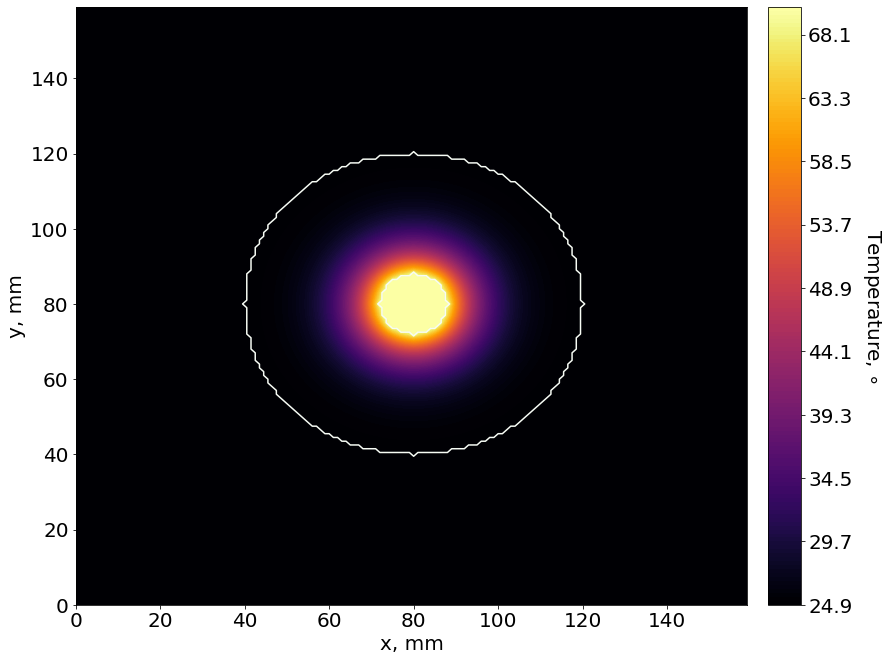

In [44]:
fig, ax = plt.subplots(figsize=(13, 11))
div = make_axes_locatable(ax)
cax = div.append_axes('right', '5%', '3%')

plt.rcParams.update({'font.size' : 20})

ax.contour(sauce_mask, cmap='Greens') #contour bondouries 
cf = ax.contourf(heat_frames[1000], 150, vmin=25, vmax=70, cmap='inferno') #simulation
ax.set_xlabel('x, mm')
ax.set_ylabel('y, mm')
#cax.cla()
cb = plt.colorbar(cf, cax=cax)
cb.ax.set_ylabel(r'Temperature, $\circ$', rotation=270, labelpad=30)

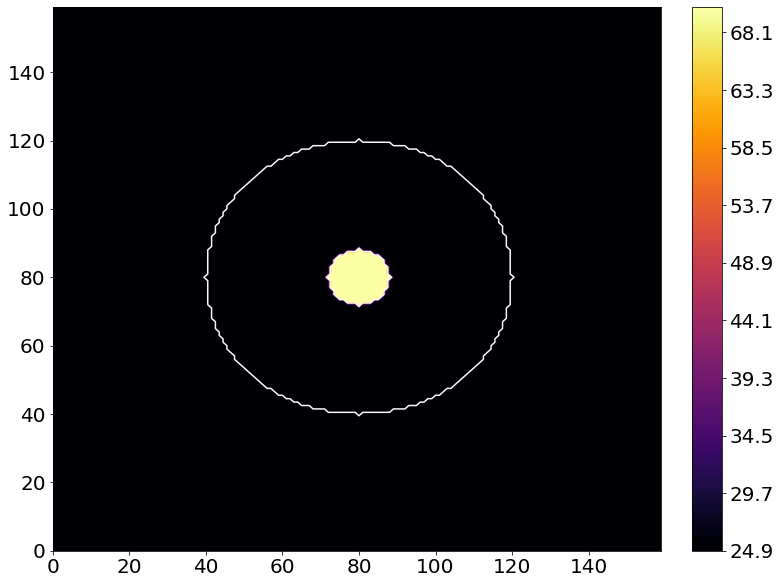

In [15]:
plt.rcParams.update({'font.size' : 20})

fig, ax = plt.subplots(figsize=(12, 10))
div = make_axes_locatable(ax)
cax = div.append_axes('right', '5%', '5%')

def animate(t):
    ax.clear()
    ax.contour(sauce_mask, cmap='Greens') #contour bondouries 
    cf = ax.contourf(heat_frames[10 * t], 150, vmin=25, vmax=70, cmap='inferno') #simulation
    cax.cla()
    fig.colorbar(cf, cax=cax)
    #plt.colorbar()

    return fig,

ani = animation.FuncAnimation(fig, animate, frames=359, interval=25)
ani.save('laser.gif', fps=30)

## Diffusive model + heat dissipations
For simple equation, such as: 
$$\frac{\partial T}{\partial t} = \alpha^2 \Delta T =  \alpha^2 [\frac{\partial^2 T}{\partial x^2} +  \frac{\partial^2 T}{\partial y^2}] + \beta (T-T_0)  $$

Eulier method: 

$$\alpha^2 [\frac{T_{i+1, j}^{(m)} - 2T_{i, j}^{(m)} + T_{i-1, j}^{(m)}}{\Delta x^2} +  \frac{T_{i, j+1}^{(m)} - 2T_{i, j}^{(m)} + T_{i, j-1}^{(m)}}{\Delta y^2}] + \beta (T_{i, j}^{(m)}-T_0) =  \frac{T_{i, j}^{(m+1)} - T_{i, j}^{(m)}}{\Delta t}$$

$$ T_{i, j}^{(m+1)} =  T_{i, j}^{(m)} + \Delta t \alpha^2 [\frac{T_{i+1, j}^{(m)} - 2T_{i, j}^{(m)} + T_{i-1, j}^{(m)}}{\Delta x^2} +  \frac{T_{i, j+1}^{(m)} - 2T_{i, j}^{(m)} + T_{i, j-1}^{(m)}}{\Delta y^2}] + \beta (T_{i, j}^{(m)}-T_0) $$

In [46]:
b = -1.2e-7

In [47]:
heat_frames_newt = np.zeros([times_snapshot, 160, 160])
heat_frames_newt[0] = temperature

In [48]:
import numba 
from numba import jit

@numba.jit("f8[:,:,:](f8[:,:,:], b1[:,:])", nopython=True, nogil=True)
def solve_heat_newtonian(heatmap, sauce_mask):
    current_state  = heatmap[0].copy()
    x_size, y_size = current_state.shape
    current_frame  = 0
    
    for t in range(1, times):
        new_state = current_state.copy()
        for i in range(1, x_size - 1):
            for j in range(1, y_size - 1):
                if sauce_mask[i][j]:
                    new_state[i][j] = current_state[i][j] + a_sauce*dt/dx_size**2 * \
                        (current_state[i+1][j] + current_state[i-1][j] + current_state[i][j+1] + current_state[i][j-1] - 4*current_state[i][j]) + \
                        b * (current_state[i][j] - initial_tempreature)
        current_state = new_state.copy()
        
        if t % frame_iteration == 0:      
            current_frame += 1
            heatmap[current_frame] = current_state

    return heatmap

In [49]:
heat_frames_newt = solve_heat_newtonian(heat_frames_newt, sauce_mask)
heat_frames_newt -= 273.15

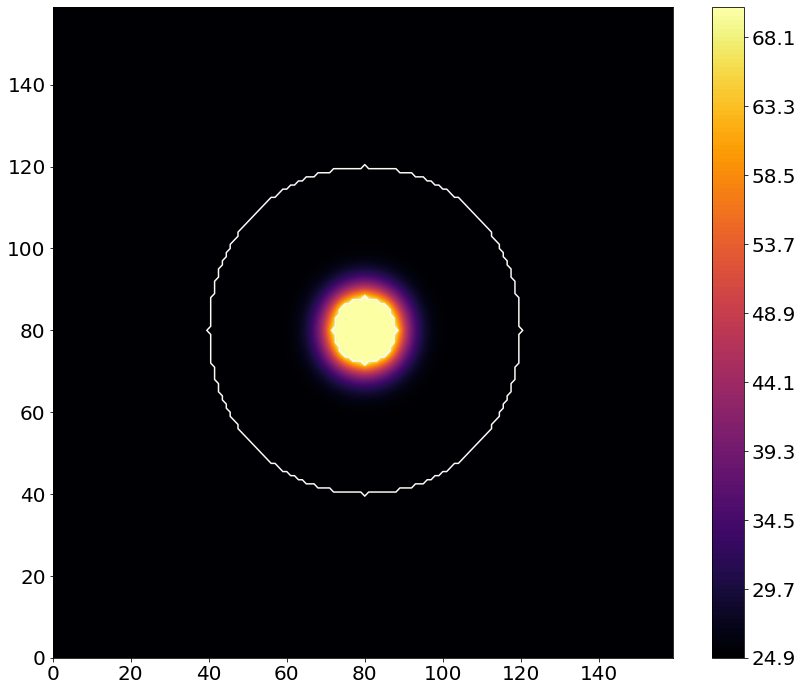

In [50]:
plt.figure(figsize=(12, 10))
plt.contour(sauce_mask, cmap='Greens')
plt.contourf(heat_frames_newt[200], 150, vmin=25, vmax=70, cmap='inferno')
plt.colorbar()
plt.tight_layout()

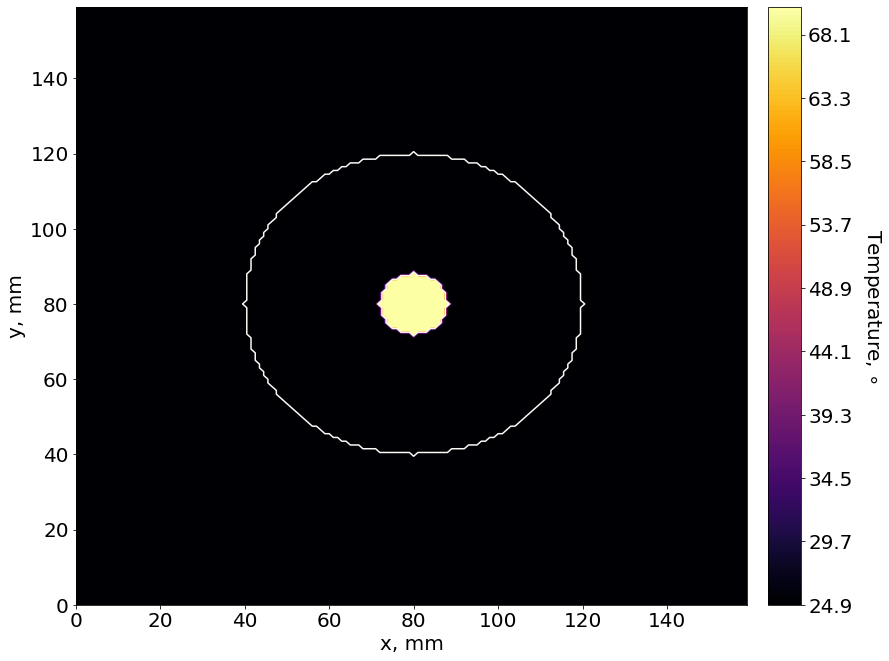

In [51]:
from matplotlib import animation
from mpl_toolkits.axes_grid1 import make_axes_locatable

plt.rcParams.update({'font.size' : 20})

fig, ax = plt.subplots(figsize=(13, 11))
div = make_axes_locatable(ax)
cax = div.append_axes('right', '5%', '3%')

def animate(t):
    ax.clear()
    ax.contour(sauce_mask, cmap='Greens') #contour bondouries 
    cf = ax.contourf(heat_frames_newt[10 * t], 150, vmin=25, vmax=70, cmap='inferno') #simulation
    ax.set_xlabel('x, mm')
    ax.set_ylabel('y, mm')
    cax.cla()
    cb = fig.colorbar(cf, cax=cax)
    cb.ax.set_ylabel(r'Temperature, $\circ$', rotation=270, labelpad=30)
    #plt.colorbar()

    return fig,

ani = animation.FuncAnimation(fig, animate, frames=359, interval=25)
ani.save('laser+diss.gif', fps=30)

References: 
1. https://www.youtube.com/watch?v=8DrR_tpfg0Q&ab_channel=Mr.PSolver
2. https://www.youtube.com/watch?v=CXOrkQs4WYo&ab_channel=YounesLab
3. https://www.youtube.com/watch?v=JFWqCQHg-Hs&ab_channel=MatiasOrtiz
4. https://mc.manuscriptcentral.com/tqe-ieee